In [6]:
# %%
import numpy as np, joblib, math
from sklearn.metrics import precision_recall_curve, auc
from goatools.obo_parser import GODag

GO_FILE = "go.obo"
dag     = GODag(GO_FILE)

# y_true + GO terms (referência ProtBERT)
test_pb = joblib.load("embeddings/test_protbert.pkl")
y_true  = test_pb["labels"]            # (1724, 597)  ← ground-truth
go_ref  = list(test_pb["go_terms"])    # ordem exacta das colunas

n_go = len(go_ref)                     # 597

# Carregar predições
y_pb   = np.load("predictions/mf-protbert-pam1.npy")        # 1724×597
y_bfd  = np.load("predictions/mf-protbertbfd-pam1.npy")     # 1724×597
y_esm0 = np.load("predictions/mf-esm2.npy")                 # 1724×602

# Remapear ESM-2 para ordem ProtBERT
mlb_esm = joblib.load("data/mlb.pkl")                       # 602 GO terms
idx_map = [list(mlb_esm.classes_).index(t) for t in go_ref]
y_esm   = y_esm0[:, idx_map]                               # 1724×597

# Garantir shapes iguais
assert (y_true.shape == y_pb.shape == y_bfd.shape
        == y_esm.shape == (1724, n_go)), "Ainda há desalinhamento!"

# Métricas
THR = np.linspace(0,1,101)
def fmax(y_t,y_p):
    best,thr = 0,0
    for t in THR:
        y_b = (y_p>=t).astype(int)
        tp = (y_t*y_b).sum(1); fp=((1-y_t)*y_b).sum(1); fn=(y_t*(1-y_b)).sum(1)
        f1 = 2*tp/(2*tp+fp+fn+1e-8); m=f1.mean()
        if m>best: best,thr = m,t
    return best,thr

def auprc(y_t,y_p):
    p,r,_ = precision_recall_curve(y_t.ravel(), y_p.ravel()); return auc(r,p)

def smin(y_t,y_p,thr,alpha=0.5):
    y_b=(y_p>=thr).astype(int)
    ic=-(np.log((y_t+y_b).sum(0)+1e-8)-np.log((y_t+y_b).sum()+1e-8))
    ru=np.logical_and(y_b, np.logical_not(y_t))*ic
    mi=np.logical_and(y_t, np.logical_not(y_b))*ic
    return np.sqrt((alpha*ru.sum(1))**2 + ((1-alpha)*mi.sum(1))**2).mean()

def show(name,y_p):
    f,thr=fmax(y_true,y_p)
    print(f"{name:>13s}  Fmax={f:.4f}  Thr={thr:.2f}  "
          f"AuPRC={auprc(y_true,y_p):.4f}  Smin={smin(y_true,y_p,thr):.4f}")

show("ProtBERT",      y_pb)
show("ProtBERT-BFD",  y_bfd)
show("ESM-2",         y_esm)
show("Ensemble",      (y_pb + y_bfd + y_esm)/3)


go.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms


C:\Users\Melvin\anaconda3\envs\protein_env\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


     ProtBERT  Fmax=0.6611  Thr=0.45  AuPRC=0.6951  Smin=13.4386
 ProtBERT-BFD  Fmax=0.6588  Thr=0.46  AuPRC=0.6991  Smin=13.5461
        ESM-2  Fmax=0.6378  Thr=0.35  AuPRC=0.6850  Smin=14.4083
     Ensemble  Fmax=0.6880  Thr=0.37  AuPRC=0.7334  Smin=12.7141


In [9]:
# %%
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import math

# Preparar dados para stacking
# (já com y_pb, y_bfd, y_esm com shape (1724, 597))
X_stack = np.concatenate([y_pb, y_bfd, y_esm], axis=1)  # (1724, 597*3)
y_stack = y_true.copy()                                # (1724, 597)

# Divisão treino/validação
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.3, random_state=42)

# Modelo MLP (usa GPU automaticamente se disponível)
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(y_stack.shape[1], activation="sigmoid")
])

model.compile(optimizer=Adam(1e-3), loss="binary_crossentropy")

model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=50, batch_size=64, verbose=1,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Prever com stacking
y_pred_stack = model.predict(X_stack, batch_size=64)

# Métricas
THR = np.linspace(0, 1, 101)
def fmax(y_t, y_p):
    best, thr = 0, 0
    for t in THR:
        y_b = (y_p >= t).astype(int)
        tp = (y_t * y_b).sum(1); fp = ((1 - y_t) * y_b).sum(1); fn = (y_t * (1 - y_b)).sum(1)
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-8); m = f1.mean()
        if m > best: best, thr = m, t
    return best, thr

def auprc(y_t, y_p):
    p, r, _ = precision_recall_curve(y_t.ravel(), y_p.ravel())
    return auc(r, p)

def smin(y_t, y_p, thr, alpha=0.5):
    y_b = (y_p >= thr).astype(int)
    ic = -(np.log((y_t + y_b).sum(0) + 1e-8) - np.log((y_t + y_b).sum() + 1e-8))
    ru = np.logical_and(y_b, np.logical_not(y_t)) * ic
    mi = np.logical_and(y_t, np.logical_not(y_b)) * ic
    return np.sqrt((alpha * ru.sum(1))**2 + ((1 - alpha) * mi.sum(1))**2).mean()

f, thr = fmax(y_stack, y_pred_stack)
print(f"\n STACKING (GPU-Keras MLP)")
print(f"Fmax  = {f:.4f}")
print(f"Thr.  = {thr:.2f}")
print(f"AuPRC = {auprc(y_stack, y_pred_stack):.4f}")
print(f"Smin  = {smin(y_stack, y_pred_stack, thr):.4f}")


Epoch 1/50
19/19 [==============================] - 1s 12ms/step - loss: 0.3895 - val_loss: 0.0855
Epoch 2/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0879 - val_loss: 0.0704
Epoch 3/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0625 - val_loss: 0.0567
Epoch 4/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0553 - val_loss: 0.0526
Epoch 5/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0508 - val_loss: 0.0484
Epoch 6/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0468 - val_loss: 0.0452
Epoch 7/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0433 - val_loss: 0.0428
Epoch 8/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.0409
Epoch 9/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0387 - val_loss: 0.0395
Epoch 10/50
19/19 [==============================] - 0s 10ms/step - loss: 0.0369 - val_loss: 0.0382
Epoch 11/50
19/19

In [11]:
model.save("models/ensemble_stack.h5")
model.save("models/ensemble_stack.keras")
print("Modelo guardado em models/")

Modelo guardado em models/


C:\Users\Melvin\anaconda3\envs\protein_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



🔎 STACKING (MLP) — Avaliação completa
Fmax  = 0.6956
Thr.  = 0.37
AuPRC = 0.7591
Smin  = 12.2272


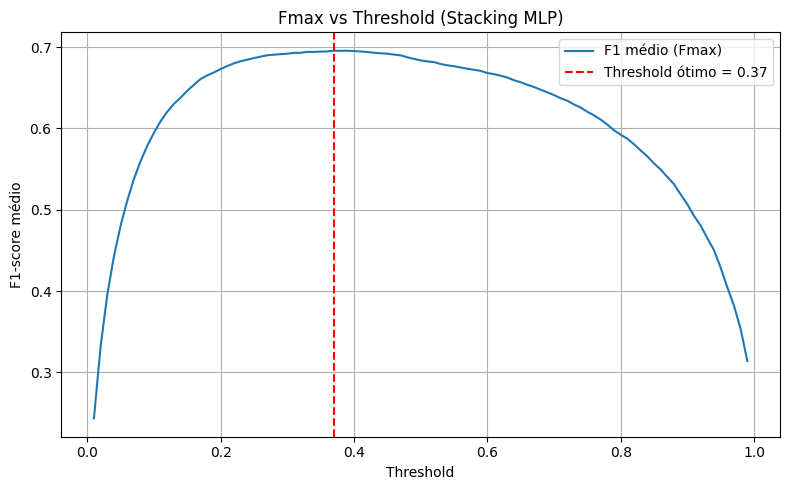

In [10]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Funções métricas
THR = np.linspace(0.01, 0.99, 99)

def fmax(y_t, y_p):
    best, thr = 0, 0
    for t in THR:
        y_b = (y_p >= t).astype(int)
        tp = (y_t * y_b).sum(1)
        fp = ((1 - y_t) * y_b).sum(1)
        fn = (y_t * (1 - y_b)).sum(1)
        f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)
        m = f1.mean()
        if m > best:
            best, thr = m, t
    return best, thr

def auprc(y_t, y_p):
    p, r, _ = precision_recall_curve(y_t.ravel(), y_p.ravel())
    return auc(r, p)

def smin(y_t, y_p, thr, alpha=0.5):
    y_b = (y_p >= thr).astype(int)
    ic = -(np.log((y_t + y_b).sum(0) + 1e-8) - np.log((y_t + y_b).sum() + 1e-8))
    ru = np.logical_and(y_b, np.logical_not(y_t)) * ic
    mi = np.logical_and(y_t, np.logical_not(y_b)) * ic
    return np.sqrt((alpha * ru.sum(1))**2 + ((1 - alpha) * mi.sum(1))**2).mean()

# Avaliação
f, thr = fmax(y_stack, y_pred_stack)
print(f"\n🔎 STACKING (MLP) — Avaliação completa")
print(f"Fmax  = {f:.4f}")
print(f"Thr.  = {thr:.2f}")
print(f"AuPRC = {auprc(y_stack, y_pred_stack):.4f}")
print(f"Smin  = {smin(y_stack, y_pred_stack, thr):.4f}")

# Gráfico Fmax vs Threshold
fmax_scores = []
for t in THR:
    y_b = (y_pred_stack >= t).astype(int)
    tp = (y_stack * y_b).sum(1)
    fp = ((1 - y_stack) * y_b).sum(1)
    fn = (y_stack * (1 - y_b)).sum(1)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)
    fmax_scores.append(f1.mean())

plt.figure(figsize=(8, 5))
plt.plot(THR, fmax_scores, label="F1 médio (Fmax)")
plt.axvline(thr, color="red", linestyle="--", label=f"Threshold ótimo = {thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score médio")
plt.title("Fmax vs Threshold (Stacking MLP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
